# Embedding Generation Notebook

## Objective
This notebook demonstrates how to use custom encoder models to generate embeddings from the MNIST dataset. These models are implemented in `encoder_models.py`, and the training processes are defined in `encoder_training.py`.

## Workflow
1. **Load and Preprocess Data**:
   - Load the MNIST dataset for testing the embedding generation process.
   - Normalize and prepare the data.
2. **Model Selection and Training**:
   - Train selected encoder models from `encoder_models.py`.
   - Generate embeddings from the bottleneck layer.
3. **Feature Extraction**:
   - Generate embeddings using matrix factorization (PCA, SVD, NMF) and SIFT.
4. **Save Embeddings**:
   - Save all embeddings and trained models for reuse.

## Models and Methods
### Supported Models
The following encoder models are available for training and embedding generation. Each model is implemented in `encoder_models.py`:
- **Encoder Models**:
  - BasicAutoencoder, IntermediateAutoencoder, AdvancedAutoencoder, EnhancedAutoencoder.
  - BasicVAE, VAEWithFCDecoder, ImprovedVAE, FlexibleVAE.
- **Feature Extraction**:
  - PCA, SVD, NMF.
  - SIFT, Kernel PCA.

#### **Autoencoders**
1. **BasicAutoencoder**:
   - A simple autoencoder with:
     - **Encoder**: Two convolutional layers followed by max-pooling.
     - **Decoder**: Two transposed convolutional layers to reconstruct the input.
   - Designed for grayscale datasets like MNIST.
   - Suitable for basic dimensionality reduction and reconstruction tasks.

2. **IntermediateAutoencoder**:
   - A deeper autoencoder with:
     - **Batch Normalization** for improved stability.
     - Additional feature maps for a more expressive latent space.
   - Designed for moderately complex embedding tasks requiring better feature extraction.

3. **AdvancedAutoencoder**:
   - A sophisticated autoencoder with:
     - **Skip Connections** to improve gradient flow and reconstruction accuracy.
     - **LeakyReLU Activations** and Batch Normalization for robust performance.
   - Suitable for high-dimensional or structured data requiring detailed reconstruction.

4. **EnhancedAutoencoder**:
   - A deeper autoencoder with:
     - Additional convolutional layers in the encoder.
     - Transposed convolutional layers in the decoder.
     - LeakyReLU activations and Batch Normalization for better embedding representation.
   - Designed for datasets requiring intricate reconstructions under noisy conditions.

#### **Variational Autoencoders (VAEs)**
5. **BasicVAE**:
   - A simple VAE with:
     - **Encoder**: Two convolutional layers and a fully connected layer to parameterize the latent space.
     - **Decoder**: Fully connected and transposed convolution layers to reconstruct input images.
   - Suitable for generative tasks with simple latent spaces.

6. **VAEWithFCDecoder**:
   - A VAE with a fully connected decoder for enhanced latent-to-feature mapping.
   - Features:
     - **Encoder**: Convolutional layers with Batch Normalization.
     - **Decoder**: A combination of fully connected and transposed convolutional layers.

7. **ImprovedVAE**:
   - An advanced VAE with:
     - A bottleneck layer for enhanced feature extraction.
     - Transposed convolutions for smooth reconstructions.
     - KL divergence loss for latent space regularization.
   - Designed for datasets requiring expressive latent representations.

8. **FlexibleVAE**:
   - A flexible VAE that supports dynamic input shapes and optional projection heads for contrastive learning.
   - Suitable for embedding tasks with varying input dimensions.

9. **ImprovedFlexibleVAE**:
   - Combines convolutional and fully connected layers in the encoder.
   - Uses transposed convolutions in the decoder for better reconstruction.
   - Optional **Projection Head** for self-supervised contrastive learning tasks.

#### **Denoising Autoencoders**
10. **DenoisingAutoencoder**:
    - A denoising autoencoder with:
      - **Encoder**: Convolutional layers for feature extraction.
      - **Decoder**: Transposed convolutional layers for reconstruction.
      - Optional **Projection Head** for contrastive learning.
    - Supports two architectures:
      - **Basic**: Simpler structure for standard denoising tasks.
      - **Strong**: Deeper architecture for challenging noisy datasets.

#### **Feature Extraction and Normalizing Flow Models**
11. **Matrix Factorization**:
    - Embeddings generated using PCA, SVD, and NMF.
    - Useful for dimensionality reduction and compact representations.

12. **SIFT (Scale-Invariant Feature Transform)**:
    - Extracts scale-invariant features from images.
    - Pads feature descriptors to ensure consistent dimensionality.

13. **Kernel PCA**:
    - Nonlinear dimensionality reduction using Kernel PCA with adjustable kernels.

14. **Normalizing Flow Models**:
    - Transforms embeddings into a latent space using invertible transformations.
    - Useful for embedding refinement and generative tasks.


**Training**:
   - Each model is trained using the corresponding training loop defined in `encoder_training.py`.
   - Training includes support for reconstruction loss, KL divergence (for VAE), and optional noise injection.
**Embedding Generation**:
   - Once the models are trained, embeddings are generated for the MNIST dataset.
   - Encodings from the bottleneck layer are extracted for downstream tasks.
**Results Storage**:
   - Save trained models to `.pth` files.
   - Save generated embeddings to `.pt` files for reuse in downstream applications.

## Supported Features
- **Flexible Model Selection**:
  - Choose specific models to train and generate embeddings for, bypassing others if needed.
- **Custom Configuration**:
  - Easily modify parameters like the bottleneck size (`code_dim`), number of training epochs, and learning rates.

## Outputs
- Trained models saved as `.pth` files.
- Generated embeddings saved as `.pt` files in a structured directory (`./embeddings`).

## Notes
This notebook is designed for flexibility and reusability. You can:
- Add new encoder models in `encoder_models.py`.
- Customize training loops in `encoder_training.py`.
- Modify this notebook to train specific models or generate embeddings for specific datasets.


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# Mount Google Drive and set repository path
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Repository path (adjust if needed)
repo_path = "/content/drive/MyDrive/GAN-thesis-project"

# Add repository path to sys.path for module imports
if repo_path not in sys.path:
    sys.path.append(repo_path)

# Change working directory to the repository
os.chdir(repo_path)

# Verify the working directory
print(f"Current working directory: {os.getcwd()}")

# Configuration
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current working directory: /content/drive/MyDrive/GAN-thesis-project
Using device: cpu


In [2]:
import inspect

# Import the entire modules
import src.data_utils as data_utils
import src.cl_loss_function as cl_loss
import src.losses as losses
import src.embeddings.encoder_models as encoder_models
import src.embeddings.encoder_training as encoder_training

# Function to list functions and classes in a module
def list_functions_and_classes(module):
    members = inspect.getmembers(module)
    functions = [name for name, obj in members if inspect.isfunction(obj)]
    classes = [name for name, obj in members if inspect.isclass(obj)]
    return functions, classes

# Function to print functions and classes in a readable format
def print_functions_and_classes(module_name, module):
    functions, classes = list_functions_and_classes(module)
    print(f"Module: {module_name}")
    print("  Functions:")
    for func in functions:
        print(f"    - {func}")
    print("  Classes:")
    for cls in classes:
        print(f"    - {cls}")
    print()  # Add a blank line for separation

# Print functions and classes for each module
print_functions_and_classes("src.data_utils", data_utils)
print_functions_and_classes("src.cl_loss_function", cl_loss)
print_functions_and_classes("src.losses", losses)
print_functions_and_classes("src.embeddings.encoder_models", encoder_models)
print_functions_and_classes("src.embeddings.encoder_training", encoder_training)

Module: src.data_utils
  Functions:
    - analyze_embeddings
    - analyze_embeddings_v2
    - create_dataloader
    - create_embedding_loaders
    - kurtosis
    - load_data
    - load_embeddings
    - load_mnist_data
    - pdist
    - preprocess_images
    - save_embeddings
    - skew
    - split_dataset
    - train_test_split
    - visualize_embeddings
  Classes:
    - DataLoader
    - LocalOutlierFactor
    - TensorDataset

Module: src.cl_loss_function
  Functions:
    - augment
    - compute_nt_xent_loss_with_augmentation
    - compute_triplet_loss_with_augmentation
    - contrastive_loss
    - hflip
    - info_nce_loss
    - resize
  Classes:
    - ContrastiveHead
    - DataLoader
    - NTXentLoss
    - PCA
    - TensorDataset
    - TripletLoss
    - VicRegLoss

Module: src.losses
  Functions:
    - add_noise
    - cyclical_beta_schedule
    - linear_beta_schedule
    - loss_function_dae_ssim
    - vae_loss
    - vae_ssim_loss
  Classes:

Module: src.embeddings.encoder_models
  F

Sampled Dataset: (70000, 1, 28, 28) (70000,)
Batch Shape: torch.Size([64, 1, 28, 28]) torch.Size([64])


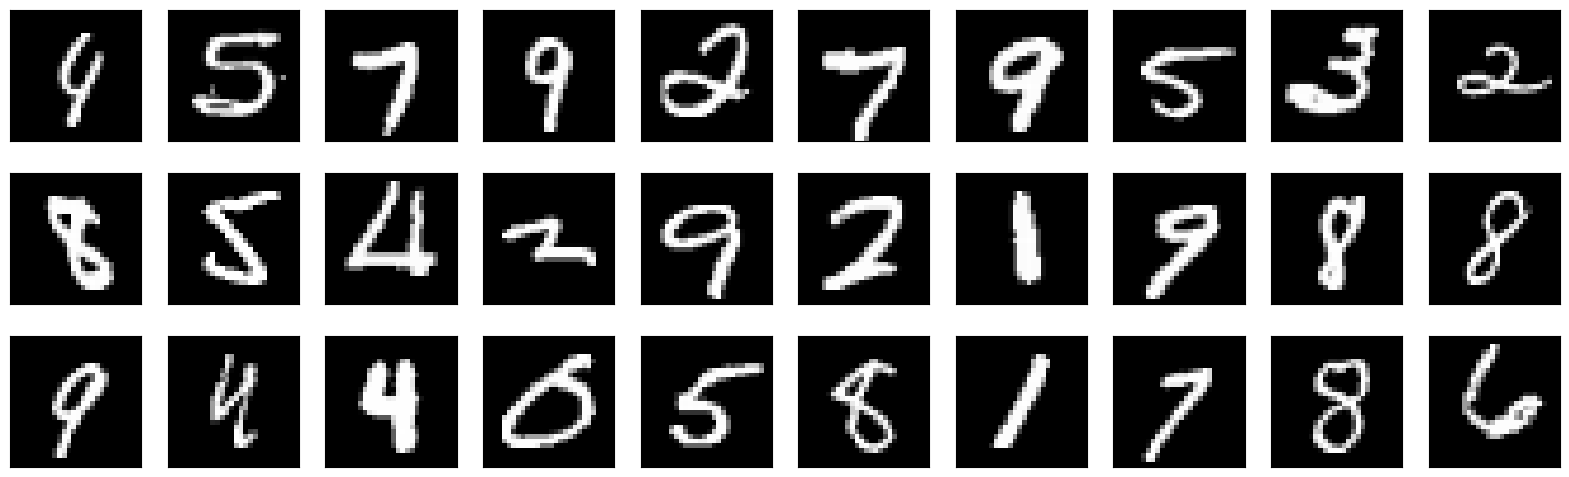

In [3]:
# Load and Preprocess MNIST Data
fraction = 1  # Fraction of the dataset to use
batch_size = 64

# Load Combined MNIST Dataset (Train + Test)
mnist_loader = data_utils.load_mnist_data(fraction=fraction, batch_size=batch_size, shuffle=True)

# Inspect Combined Dataset
for batch in mnist_loader:
    images, labels = batch
    print("Batch Shape:", images.shape, labels.shape)
    break

# Visualize Original Images
n = 30
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [4]:
# def generate_embeddings(model, data_loader, embedding_type, device="cpu"):
#     model.eval()  # Set model to evaluation mode
#     embeddings = []
#     labels = []

#     with torch.no_grad():
#         for images, label_batch in data_loader:
#             images = images.to(device)
#             if embedding_type == "autoencoder":
#                 encoded, _ = model(images)
#             elif embedding_type == "vae":
#                 mu, _, _ = model(images)
#                 encoded = mu  # Use the mean of the latent space
#             elif embedding_type == "dae":
#                 _, _, encoded = model(images)
#             else:
#                 raise ValueError(f"Embedding type '{embedding_type}' is not recognized.")

#             embeddings.append(encoded.cpu())
#             labels.append(label_batch)

#     embeddings = torch.cat(embeddings, dim=0)
#     labels = torch.cat(labels, dim=0)

#     return embeddings, labels

In [105]:
# import torch.nn.functional as F

# class NTXentLoss(nn.Module):
#     def __init__(self, temperature=0.5):
#         super(NTXentLoss, self).__init__()
#         self.temperature = temperature

#     def forward(self, z_i, z_j):
#         batch_size = z_i.size(0)

#         # Flatten the input tensors if they are not already 2D
#         z_i = z_i.view(z_i.size(0), -1)  # Shape: (batch_size, embedding_dim)
#         z_j = z_j.view(z_j.size(0), -1)  # Shape: (batch_size, embedding_dim)

#         # Normalize the embeddings
#         z_i = F.normalize(z_i, dim=1)
#         z_j = F.normalize(z_j, dim=1)

#         # Concatenate the embeddings
#         z = torch.cat([z_i, z_j], dim=0)  # Shape: (2 * batch_size, embedding_dim)

#         # Compute the similarity matrix
#         similarity_matrix = torch.matmul(z, z.T) / self.temperature  # Shape: (2 * batch_size, 2 * batch_size)

#         # Mask for positives and negatives
#         mask = ~torch.eye(2 * batch_size, device=z.device).bool()
#         positives = torch.cat([
#             torch.diag(similarity_matrix, batch_size),  # Positive pairs (z_i, z_j)
#             torch.diag(similarity_matrix, -batch_size)  # Positive pairs (z_j, z_i)
#         ])
#         negatives = similarity_matrix.masked_select(mask).view(2 * batch_size, -1)

#         # Compute the NT-Xent loss
#         numerator = torch.exp(positives)
#         denominator = torch.sum(torch.exp(negatives), dim=-1)
#         loss = -torch.mean(torch.log(numerator / denominator))

#         return loss

# class VicRegLoss(nn.Module):
#     def __init__(self, lambda_var=25, mu_mean=25, nu_cov=1):
#         super(VicRegLoss, self).__init__()
#         self.lambda_var = lambda_var
#         self.mu_mean = mu_mean
#         self.nu_cov = nu_cov

#     def forward(self, z1, z2):
#         # Flatten z1 and z2 if they are 4D
#         if z1.dim() == 4:
#             z1 = z1.view(z1.size(0), -1)  # Shape: (batch_size, 1 * 28 * 28)
#         if z2.dim() == 4:
#             z2 = z2.view(z2.size(0), -1)  # Shape: (batch_size, 1 * 28 * 28)

#         # Variance loss
#         variance_loss = torch.mean(torch.relu(1 - torch.std(z1, dim=0))) + \
#                         torch.mean(torch.relu(1 - torch.std(z2, dim=0)))

#         # Mean loss
#         mean_loss = torch.mean((torch.mean(z1, dim=0) - torch.mean(z2, dim=0))**2)

#         # Covariance loss
#         z1_centered = z1 - z1.mean(dim=0)
#         z2_centered = z2 - z2.mean(dim=0)

#         covariance_matrix_z1 = torch.mm(z1_centered.T, z1_centered) / (z1.size(0) - 1)
#         covariance_matrix_z2 = torch.mm(z2_centered.T, z2_centered) / (z2.size(0) - 1)

#         covariance_loss = torch.sum(covariance_matrix_z1 ** 2) - torch.sum(torch.diag(covariance_matrix_z1) ** 2) + \
#                           torch.sum(covariance_matrix_z2 ** 2) - torch.sum(torch.diag(covariance_matrix_z2) ** 2)

#         # Total loss
#         total_loss = self.lambda_var * variance_loss + \
#                      self.mu_mean * mean_loss + \
#                      self.nu_cov * covariance_loss
#         return total_loss

# class TripletLoss(nn.Module):
#     def __init__(self, margin=1.0):
#         super(TripletLoss, self).__init__()
#         self.margin = margin
#         self.criterion = nn.TripletMarginWithDistanceLoss(
#             distance_function=lambda a, b: 1.0 - F.cosine_similarity(a, b),
#             margin=self.margin
#         )

#     def forward(self, anchor, positive, negative):
#         return self.criterion(anchor, positive, negative)

# class BarlowTwinsLoss(nn.Module):
#     def __init__(self, lambda_param=5e-3):
#         super(BarlowTwinsLoss, self).__init__()
#         self.lambda_param = lambda_param

#     def forward(self, z_a, z_b):
#         """
#         Compute the Barlow Twins loss between two sets of embeddings.

#         Args:
#             z_a (torch.Tensor): First set of embeddings.
#             z_b (torch.Tensor): Second set of embeddings.

#         Returns:
#             torch.Tensor: Computed Barlow Twins loss.
#         """
#         batch_size = z_a.size(0)
#         feature_dim = z_a.size(1)

#         # Normalize embeddings
#         z_a = (z_a - z_a.mean(dim=0)) / z_a.std(dim=0)
#         z_b = (z_b - z_b.mean(dim=0)) / z_b.std(dim=0)

#         # Compute cross-correlation matrix
#         cross_corr = torch.matmul(z_a.T, z_b) / batch_size

#         # Loss terms
#         invariance_loss = torch.sum((1 - torch.diag(cross_corr)) ** 2)
#         redundancy_loss = torch.sum(torch.triu(cross_corr, diagonal=1) ** 2) + torch.sum(torch.tril(cross_corr, diagonal=-1) ** 2)

#         # Total loss
#         loss = invariance_loss + self.lambda_param * redundancy_loss
#         return loss

# class BYOLLoss(nn.Module):
#     def __init__(self):
#         super(BYOLLoss, self).__init__()

#     def forward(self, z_a, z_b, predictor):
#         """
#         Compute the BYOL loss between two sets of embeddings.

#         Args:
#             z_a (torch.Tensor): First set of embeddings.
#             z_b (torch.Tensor): Second set of embeddings.
#             predictor (nn.Module): Predictor network.

#         Returns:
#             torch.Tensor: Computed BYOL loss.
#         """
#         # Normalize embeddings
#         z_a = F.normalize(z_a, dim=1)
#         z_b = F.normalize(z_b, dim=1)

#         # Predict z_b from z_a
#         p_a = predictor(z_a)
#         p_a = F.normalize(p_a, dim=1)

#         # Compute MSE loss between predicted and target embeddings
#         loss = 2 - 2 * (p_a * z_b).sum(dim=1).mean()
#         return loss

# class Predictor(nn.Module):
#     def __init__(self, input_dim, hidden_dim=512, output_dim=50):
#         super(Predictor, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.BatchNorm1d(hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, output_dim),
#         )

#     def forward(self, x):
#         return self.net(x)

In [22]:
from typing import Callable, Optional

def train_autoencoder(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    device: str = "cpu",
    noise_factor: float = 0.0,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    contrastive_loss_fn: Optional[Callable] = None,
    temperature: float = 0.5,
    triplet_data: bool = False,
    augment_fn: Optional[Callable] = None,
    patience: int = 5,
    min_delta: float = 0.001,
):
    """
    Unified training function for autoencoders with support for:
    - Reconstruction loss
    - Contrastive loss (e.g., NT-Xent, InfoNCE)
    - Triplet loss
    - Noise injection (for denoising autoencoders)
    - Data augmentation
    - Early stopping

    Args:
        model (nn.Module): The autoencoder model.
        data_loader (DataLoader): DataLoader for training data.
        loss_fn (Callable): Primary loss function (e.g., reconstruction loss).
        optimizer (optim.Optimizer): Optimizer for the model.
        epochs (int): Number of epochs to train.
        device (str): Device to train on ('cpu' or 'cuda').
        noise_factor (float): Factor for adding noise to input images (denoising autoencoder).
        scheduler (Optional[optim.lr_scheduler._LRScheduler]): Learning rate scheduler.
        contrastive_loss_fn (Optional[Callable]): Contrastive loss function (e.g., NT-Xent, triplet loss).
        temperature (float): Temperature parameter for NT-Xent loss.
        triplet_data (bool): Whether the data_loader provides triplets (anchor, positive, negative).
        augment_fn (Optional[Callable]): Augmentation function for contrastive learning.
        patience (int): Number of epochs with no significant improvement before triggering early stopping.
        min_delta (float): Minimum change in loss to qualify as an improvement.

    Returns:
        None: Prints loss values for each epoch.
    """
    model.to(device).train()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            # Prepare data based on whether it's triplet data or not
            if triplet_data:
                anchor, positive, negative = batch
                anchor, positive, negative = (
                    anchor.to(device).float(),
                    positive.to(device).float(),
                    negative.to(device).float(),
                )
                images = anchor  # Use anchor as the primary input for reconstruction
            else:
                images, _ = batch
                images = images.to(device).float()

            # Add noise if specified
            if noise_factor > 0:
                noisy_images = images + noise_factor * torch.randn_like(images)
                noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
                encoded, decoded = model(noisy_images)
            else:
                encoded, decoded = model(images)

            # Compute reconstruction loss
            reconstruction_loss = loss_fn(decoded, images)

            # Compute contrastive loss if specified
            contrastive_loss_value = 0
            if contrastive_loss_fn is not None:
                if triplet_data:
                    # Triplet loss
                    positive_encoded, _ = model(positive)
                    negative_encoded, _ = model(negative)
                    contrastive_loss_value = contrastive_loss_fn(encoded, positive_encoded, negative_encoded)
                else:
                    # NT-Xent, VicReg, or other contrastive loss
                    if augment_fn:
                        augmented_1 = augment_fn(images)
                        augmented_2 = augment_fn(images)
                        z1, _ = model(augmented_1)
                        z2, _ = model(augmented_2)
                    else:
                        z1, z2 = encoded, encoded  # Use the same embeddings if no augmentation

                    # Handle different contrastive loss functions
                    if isinstance(contrastive_loss_fn, NTXentLoss):
                        # NT-Xent loss requires temperature
                        contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature)
                    elif isinstance(contrastive_loss_fn, VicRegLoss):
                        # VicReg loss does not require temperature
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)
                    else:
                        # Default behavior for other contrastive losses
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)

            # Total loss
            total_loss_value = reconstruction_loss + contrastive_loss_value

            # Backpropagation
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_loss += total_loss_value.item()

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Compute average epoch loss
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}")

        # Check for early stopping
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

class EarlyStopping:
    """
    Early stopping to stop training when the loss does not improve after a specified number of epochs (patience).
    """
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): Number of epochs to wait for improvement before stopping.
            min_delta (float): Minimum change in loss to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, current_loss):
        """
        Check if training should stop.

        Args:
            current_loss (float): Current epoch's loss.
        """
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [25]:
def train_autoencoder_v2(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    device: str = "cpu",
    noise_factor: float = 0.0,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    contrastive_loss_fn: Optional[Callable] = None,
    temperature: float = 0.5,
    triplet_data: bool = False,
    augment_fn: Optional[Callable] = None,
    patience: int = 5,
    min_delta: float = 0.001,
):
    """
    Unified training function for autoencoders with support for:
    - Reconstruction loss
    - Contrastive loss (e.g., NT-Xent, VicReg, Triplet)
    - Noise injection (for denoising autoencoders)
    - Data augmentation
    - Early stopping

    Args:
        model (nn.Module): The autoencoder model.
        data_loader (DataLoader): DataLoader for training data.
        loss_fn (Callable): Primary loss function (e.g., reconstruction loss).
        optimizer (optim.Optimizer): Optimizer for the model.
        epochs (int): Number of epochs to train.
        device (str): Device to train on ('cpu' or 'cuda').
        noise_factor (float): Factor for adding noise to input images (denoising autoencoder).
        scheduler (Optional[optim.lr_scheduler._LRScheduler]): Learning rate scheduler.
        contrastive_loss_fn (Optional[Callable]): Contrastive loss function (e.g., NT-Xent, VicReg, Triplet).
        temperature (float): Temperature parameter for NT-Xent loss.
        triplet_data (bool): Whether the data_loader provides triplets (anchor, positive, negative).
        augment_fn (Optional[Callable]): Augmentation function for contrastive learning.
        patience (int): Number of epochs with no significant improvement before triggering early stopping.
        min_delta (float): Minimum change in loss to qualify as an improvement.

    Returns:
        None: Prints loss values for each epoch.
    """
    model.to(device).train()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            # Prepare data based on whether it's triplet data or not
            if triplet_data:
                anchor, positive, negative = batch
                anchor, positive, negative = (
                    anchor.to(device).float(),
                    positive.to(device).float(),
                    negative.to(device).float(),
                )
                images = anchor  # Use anchor as the primary input for reconstruction
            else:
                images, _ = batch
                images = images.to(device).float()

            # Add noise if specified
            if noise_factor > 0:
                noisy_images = images + noise_factor * torch.randn_like(images)
                noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
                encoded, decoded = model(noisy_images)
            else:
                encoded, decoded = model(images)

            # Compute reconstruction loss
            reconstruction_loss = loss_fn(decoded, images)

            # Compute contrastive loss if specified
            contrastive_loss_value = 0
            if contrastive_loss_fn is not None:
                if triplet_data:
                    # Triplet loss
                    positive_encoded, _ = model(positive)
                    negative_encoded, _ = model(negative)

                    # Flatten embeddings
                    encoded = encoded.view(encoded.size(0), -1)
                    positive_encoded = positive_encoded.view(positive_encoded.size(0), -1)
                    negative_encoded = negative_encoded.view(negative_encoded.size(0), -1)

                    contrastive_loss_value = contrastive_loss_fn(encoded, positive_encoded, negative_encoded)
                else:
                    # NT-Xent, VicReg, or other contrastive loss
                    if augment_fn:
                        augmented_1 = augment_fn(images)
                        augmented_2 = augment_fn(images)
                        z1, _ = model(augmented_1)
                        z2, _ = model(augmented_2)
                    else:
                        z1, z2 = encoded, encoded  # Use the same embeddings if no augmentation

                    # Flatten embeddings
                    z1 = z1.view(z1.size(0), -1)
                    z2 = z2.view(z2.size(0), -1)

                    # Handle different contrastive loss functions
                    if isinstance(contrastive_loss_fn, NTXentLoss):
                        # NT-Xent loss does not require temperature in forward()
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)
                    elif isinstance(contrastive_loss_fn, VicRegLoss):
                        # VicReg loss does not require temperature
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)
                    else:
                        # Default behavior for other contrastive losses
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)

            # Total loss
            total_loss_value = reconstruction_loss + contrastive_loss_value

            # Backpropagation
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_loss += total_loss_value.item()

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Compute average epoch loss
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}")

        # Check for early stopping
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

In [81]:
def train_autoencoder_v3(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    device: str = "cpu",
    noise_factor: float = 0.0,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    contrastive_loss_fn: Optional[Callable] = None,
    temperature: float = 0.5,
    triplet_data: bool = False,
    augment_fn: Optional[Callable] = None,
    patience: int = 5,
    min_delta: float = 0.001,
):
    """
    Unified training function for autoencoders with support for:
    - Reconstruction loss
    - Contrastive loss (e.g., NT-Xent, VicReg, Triplet)
    - Noise injection (for denoising autoencoders)
    - Data augmentation
    - Early stopping

    Args:
        model (nn.Module): The autoencoder model.
        data_loader (DataLoader): DataLoader for training data.
        loss_fn (Callable): Primary loss function (e.g., reconstruction loss).
        optimizer (optim.Optimizer): Optimizer for the model.
        epochs (int): Number of epochs to train.
        device (str): Device to train on ('cpu' or 'cuda').
        noise_factor (float): Factor for adding noise to input images (denoising autoencoder).
        scheduler (Optional[optim.lr_scheduler._LRScheduler]): Learning rate scheduler.
        contrastive_loss_fn (Optional[Callable]): Contrastive loss function (e.g., NT-Xent, VicReg, Triplet).
        temperature (float): Temperature parameter for NT-Xent loss.
        triplet_data (bool): Whether the data_loader provides triplets (anchor, positive, negative).
        augment_fn (Optional[Callable]): Augmentation function for contrastive learning.
        patience (int): Number of epochs with no significant improvement before triggering early stopping.
        min_delta (float): Minimum change in loss to qualify as an improvement.

    Returns:
        None: Prints loss values for each epoch.
    """
    model.to(device).train()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            # Prepare data based on whether it's triplet data or not
            if triplet_data:
                anchor, positive, negative = batch
                anchor, positive, negative = (
                    anchor.to(device).float(),
                    positive.to(device).float(),
                    negative.to(device).float(),
                )
                images = anchor  # Use anchor as the primary input for reconstruction
            else:
                images, _ = batch
                images = images.to(device).float()

            # Add noise if specified
            if noise_factor > 0:
                noisy_images = images + noise_factor * torch.randn_like(images)
                noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
                encoded, decoded = model(noisy_images)
            else:
                encoded, decoded = model(images)

            # Compute reconstruction loss
            reconstruction_loss = loss_fn(decoded, images)

            # Compute contrastive loss if specified
            contrastive_loss_value = 0
            if contrastive_loss_fn is not None:
                if triplet_data:
                    # Triplet loss
                    positive_encoded, _ = model(positive)
                    negative_encoded, _ = model(negative)

                    # Flatten embeddings
                    encoded = encoded.view(encoded.size(0), -1)
                    positive_encoded = positive_encoded.view(positive_encoded.size(0), -1)
                    negative_encoded = negative_encoded.view(negative_encoded.size(0), -1)

                    contrastive_loss_value = contrastive_loss_fn(encoded, positive_encoded, negative_encoded)
                else:
                    # NT-Xent, VicReg, or other contrastive loss
                    if augment_fn:
                        augmented_1 = augment_fn(images)
                        augmented_2 = augment_fn(images)
                        z1, _ = model(augmented_1)
                        z2, _ = model(augmented_2)
                    else:
                        z1, z2 = encoded, encoded  # Use the same embeddings if no augmentation

                    # Flatten embeddings
                    z1 = z1.view(z1.size(0), -1)
                    z2 = z2.view(z2.size(0), -1)

                    # # Handle different contrastive loss functions
                    # if contrastive_loss_fn.__name__ == "contrastive_loss":
                    #     # Basic contrastive loss
                    #     contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature)
                    # elif contrastive_loss_fn.__name__ == "info_nce_loss":
                    #     # InfoNCE loss
                    #     contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature)
                    if isinstance(contrastive_loss_fn, NTXentLoss):
                        # NT-Xent loss does not require temperature in forward()
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)
                    elif isinstance(contrastive_loss_fn, VicRegLoss):
                        # VicReg loss does not require temperature
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)
                    else:
                        # Default behavior for other contrastive losses
                        contrastive_loss_value = contrastive_loss_fn(z1, z2)

                    # # Handle all contrastive losses uniformly
                    # if hasattr(contrastive_loss_fn, "temperature"):
                    #     # Pass temperature to loss functions that require it
                    #     contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature=temperature)
                    # else:
                    #     # For loss functions that don't use temperature
                    #     contrastive_loss_value = contrastive_loss_fn(z1, z2)

            # Total loss
            total_loss_value = reconstruction_loss + contrastive_loss_value

            # Backpropagation
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_loss += total_loss_value.item()

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Compute average epoch loss
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}")

        # Check for early stopping
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

In [122]:
import inspect

def train_autoencoder_v4(
    model: nn.Module,
    data_loader: DataLoader,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    epochs: int = 10,
    device: str = "cpu",
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    contrastive_loss_fn: Optional[Callable] = None,
    temperature: float = 0.5,
    triplet_data: bool = False,
    augment_fn: Optional[Callable] = None,
    predictor: Optional[nn.Module] = None,  # Add predictor for BYOL
    patience: int = 5,
    min_delta: float = 0.001,
):
    """
    Unified training function for autoencoders with support for:
    - Reconstruction loss
    - Contrastive loss (e.g., NT-Xent, VicReg, Triplet, Contrastive, InfoNCE, Barlow Twins, BYOL)
    - Noise injection (for denoising autoencoders)
    - Data augmentation
    - Early stopping
    """
    model.to(device).train()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)

    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            # Prepare data based on whether it's triplet data or not
            if triplet_data:
                anchor, positive, negative = batch
                anchor, positive, negative = (
                    anchor.to(device).float(),
                    positive.to(device).float(),
                    negative.to(device).float(),
                )
                images = anchor  # Use anchor as the primary input for reconstruction
            else:
                images, _ = batch
                images = images.to(device).float()

            encoded, decoded = model(images)

            # Compute reconstruction loss
            reconstruction_loss = loss_fn(decoded, images)

            # Compute contrastive loss if specified
            contrastive_loss_value = 0
            if contrastive_loss_fn is not None:
                if triplet_data:
                    # Triplet loss
                    positive_encoded, _ = model(positive)
                    negative_encoded, _ = model(negative)

                    # Flatten embeddings
                    encoded = encoded.view(encoded.size(0), -1)
                    positive_encoded = positive_encoded.view(positive_encoded.size(0), -1)
                    negative_encoded = negative_encoded.view(negative_encoded.size(0), -1)

                    # Compute triplet loss
                    contrastive_loss_value = contrastive_loss_fn(encoded, positive_encoded, negative_encoded)
                else:
                    # NT-Xent, VicReg, Contrastive, InfoNCE, Barlow Twins, BYOL, or other contrastive loss
                    if augment_fn:
                        augmented_1 = augment_fn(images)
                        augmented_2 = augment_fn(images)
                        z1, _ = model(augmented_1)
                        z2, _ = model(augmented_2)
                    else:
                        z1, z2 = encoded, encoded  # Use the same embeddings if no augmentation

                    # Flatten embeddings
                    z1 = z1.view(z1.size(0), -1)
                    z2 = z2.view(z2.size(0), -1)

                    # Handle all contrastive losses uniformly
                    if isinstance(contrastive_loss_fn, BYOLLoss):
                        # BYOL requires a predictor
                        if predictor is None:
                            raise ValueError("Predictor network must be provided for BYOL loss.")
                        contrastive_loss_value = contrastive_loss_fn(z1, z2, predictor)
                    else:
                        # # Check if the loss function accepts a `temperature` parameter
                        # if "temperature" in inspect.signature(contrastive_loss_fn.forward).parameters:
                        #     contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature=temperature)
                        # else:
                        #     contrastive_loss_value = contrastive_loss_fn(z1, z2)
                        # Check if the loss function accepts a `temperature` parameter
                        if "temperature" in inspect.signature(contrastive_loss_fn).parameters:
                            contrastive_loss_value = contrastive_loss_fn(z1, z2, temperature=temperature)
                        else:
                            contrastive_loss_value = contrastive_loss_fn(z1, z2)

            # Total loss
            total_loss_value = reconstruction_loss + contrastive_loss_value

            # Backpropagation
            optimizer.zero_grad()
            total_loss_value.backward()
            optimizer.step()

            total_loss += total_loss_value.item()

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        # Compute average epoch loss
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.4f}")

        # Check for early stopping
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}.")
            break

Sampled Dataset: (700, 1, 28, 28) (700,)
Batch Shape: torch.Size([64, 1, 28, 28]) torch.Size([64])


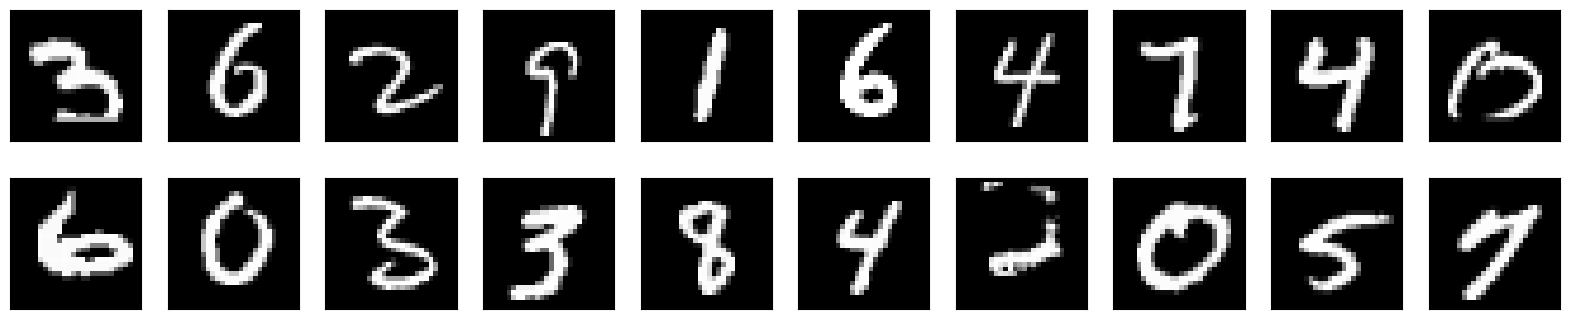

Training EnhancedAutoencoder with ntxent loss...
Epoch [1/100], Train Loss: 8.9189


KeyboardInterrupt: 

In [100]:
# ------------------------------
# Step 1: Define Configuration
# ------------------------------

# Configuration
config = {
    "model_type": "autoencoder",  # Options: "autoencoder", "vae", "dae"
    "model_name": "EnhancedAutoencoder",  # Options: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder", "BasicVAE", "ImprovedVAE", "FlexibleVAE", "ImprovedFlexibleVAE", "DenoisingAutoencoder"
    "code_dim": 50,  # Dimensionality of the embedding
    "loss_type": "ntxent",  # Options: "mse", "vicreg", "ntxent", "triplet"
    "noise_factor": 0.1,  # Noise factor for denoising autoencoders
    "temperature": 0.5,  # Temperature parameter for NT-Xent loss
    "margin": 1.0,  # Margin for Triplet Loss
    "epochs": 100,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_best": True,  # Whether to save the best model
    "save_path": "best_model.pth",  # Path to save the best model
    "beta": 1.0,  # Weight for KL divergence (VAE only)
    "alpha": 0.5,  # Weight for contrastive or triplet loss
    "fraction": 0.01,  # Fraction of the dataset to use
    "projection_dim": None,  # Optional projection head dimension for VAEs
    "strong_architecture": False,  # Whether to use a deeper architecture for DenoisingAutoencoder
    "input_shape": (1, 28, 28),  # Input shape for FlexibleVAE and ImprovedFlexibleVAE
    "patience": 5,
    "min_delta": 0.001,
    "triplet_data": False,
}

# ------------------------------
# Step 2: Load and Preprocess Data
# ------------------------------

# Load Combined MNIST Dataset (Train + Test)
mnist_loader = data_utils.load_mnist_data(fraction=config["fraction"], batch_size=config["batch_size"], shuffle=True)

# Inspect Combined Dataset
for batch in mnist_loader:
    images, labels = batch
    print("Batch Shape:", images.shape, labels.shape)
    break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# ------------------------------
# Step 3: Initialize Model, Loss, and Optimizer
# ------------------------------

# Initialize the model
model_classes = {
    "BasicAutoencoder": encoder_models.BasicAutoencoder,
    "IntermediateAutoencoder": encoder_models.IntermediateAutoencoder,
    "AdvancedAutoencoder": encoder_models.AdvancedAutoencoder,
    "EnhancedAutoencoder": encoder_models.EnhancedAutoencoder,
    "BasicVAE": encoder_models.BasicVAE,
    "ImprovedVAE": encoder_models.ImprovedVAE,
    "FlexibleVAE": encoder_models.FlexibleVAE,
    "ImprovedFlexibleVAE": encoder_models.ImprovedFlexibleVAE,
    "DenoisingAutoencoder": encoder_models.DenoisingAutoencoder,
}

# Initialize model with appropriate arguments
if config["model_name"] in ["FlexibleVAE", "ImprovedFlexibleVAE"]:
    model = model_classes[config["model_name"]](
        input_shape=config["input_shape"],
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"]
    ).to(config["device"])
elif config["model_name"] == "DenoisingAutoencoder":
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"],
        strong_architecture=config["strong_architecture"]
    ).to(config["device"])
else:
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"]
    ).to(config["device"])

# Define the loss function
if config["model_type"] == "vae":
    criterion = losses.vae_loss  # Use VAE loss for VAEs
else:
    loss_functions = {
        "mse": nn.MSELoss(),  # Reconstruction loss
        "vicreg": VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
        "ntxent": NTXentLoss(temperature=config["temperature"]),
        # cl_loss.NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
        "triplet": TripletLoss(margin=config["margin"]),  # Triplet loss
    }
    criterion = loss_functions[config["loss_type"]]

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 4: Train the Model
# ------------------------------

if config["model_type"] == "autoencoder":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    train_autoencoder_v3(
        model=model,
        data_loader=mnist_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        epochs=config["epochs"],
        device=config["device"],
        # noise_factor=config["noise_factor"],
        scheduler=scheduler,
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "triplet"] else None,
        # triplet_data=(config["loss_type"] != "triplet"),
        augment_fn=cl_loss.augment if config["loss_type"] in ["vicreg", "ntxent"] else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "vae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_vae(
        vae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        beta=config["beta"],
        alpha=config["alpha"],
        temperature=config["temperature"],
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent"] else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "dae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_dae(
        dae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        noise_factor=config["noise_factor"],
        alpha=config["alpha"],
        temperature=config["temperature"],
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent"] else None,
        triplet_loss_fn=criterion if config["loss_type"] == "triplet" else None,
        ssim_func=losses.ssim if config["loss_type"] == "ssim" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Generate embeddings
embeddings, labels = data_utils.generate_embeddings(
    model=model,
    embedding_type=config["model_type"],
    data_loader=mnist_loader,
    device=config["device"],
)

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{config['model_type']}_{config['model_name']}_{config['loss_type']}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

# ------------------------------
# Step 6: Visualize Embeddings
# ------------------------------

# Visualize embeddings


Sampled Dataset: (700, 1, 28, 28) (700,)
Batch Shape: torch.Size([64, 1, 28, 28]) torch.Size([64])


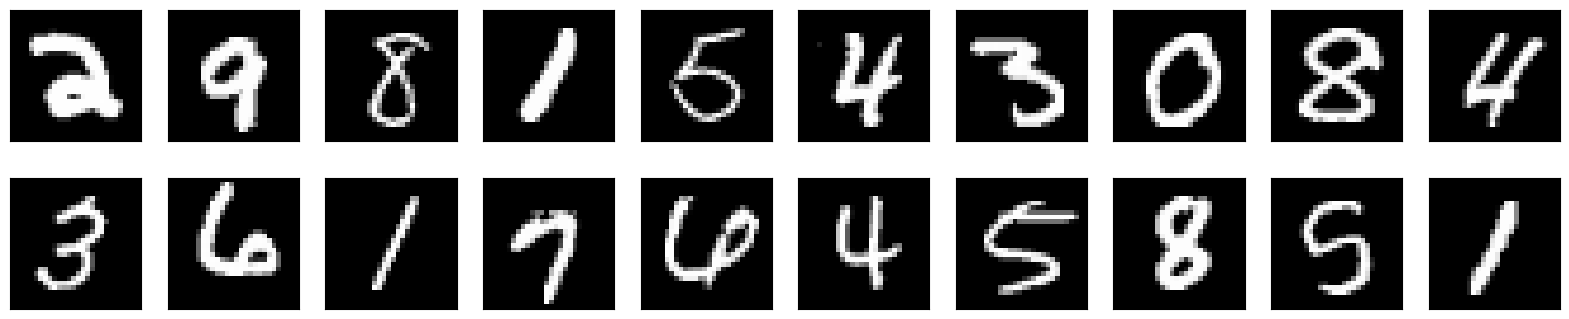

Training EnhancedAutoencoder with ntxent loss...
Epoch [1/100], Train Loss: 4.5143


KeyboardInterrupt: 

In [129]:
# ------------------------------
# Step 1: Define Configuration
# ------------------------------

# Configuration
config = {
    "model_type": "autoencoder",  # Options: "autoencoder", "vae", "dae"
    "model_name": "EnhancedAutoencoder",  # Options: "BasicAutoencoder", "IntermediateAutoencoder", "AdvancedAutoencoder", "EnhancedAutoencoder", "BasicVAE", "ImprovedVAE", "FlexibleVAE", "ImprovedFlexibleVAE", "DenoisingAutoencoder"
    "code_dim": 50,  # Dimensionality of the embedding
    "loss_type": "ntxent",  # Options: "mse", "vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"
    "noise_factor": 0.1,  # Noise factor for denoising autoencoders
    "temperature": 0.5,  # Temperature parameter for NT-Xent loss
    "margin": 1.0,  # Margin for Triplet Loss
    "epochs": 100,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_best": True,  # Whether to save the best model
    "save_path": "best_model.pth",  # Path to save the best model
    "beta": 1.0,  # Weight for KL divergence (VAE only)
    "alpha": 0.5,  # Weight for contrastive or triplet loss
    "fraction": 0.01,  # Fraction of the dataset to use
    "projection_dim": None,  # Optional projection head dimension for VAEs
    "strong_architecture": False,  # Whether to use a deeper architecture for DenoisingAutoencoder
    "input_shape": (1, 28, 28),  # Input shape for FlexibleVAE and ImprovedFlexibleVAE
    "patience": 5,
    "min_delta": 0.001,
    "triplet_data": False,
}

# ------------------------------
# Step 2: Load and Preprocess Data
# ------------------------------

# Load Combined MNIST Dataset (Train + Test)
mnist_loader = data_utils.load_mnist_data(fraction=config["fraction"], batch_size=config["batch_size"], shuffle=True)

# Inspect Combined Dataset
for batch in mnist_loader:
    images, labels = batch
    print("Batch Shape:", images.shape, labels.shape)
    break

# Visualize Original Images
n = 20
sample_indices = np.random.choice(len(mnist_loader.dataset), n, replace=False)
sampled_images = mnist_loader.dataset.tensors[0][sample_indices].numpy()
sampled_images = (sampled_images * 127.5 + 127.5).astype(np.uint8).squeeze()  # Denormalize for display

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(sampled_images[i], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# ------------------------------
# Step 3: Initialize Model, Loss, and Optimizer
# ------------------------------

# Initialize the model
# Initialize the model
model_classes = {
    "BasicAutoencoder": encoder_models.BasicAutoencoder,
    "IntermediateAutoencoder": encoder_models.IntermediateAutoencoder,
    "AdvancedAutoencoder": encoder_models.AdvancedAutoencoder,
    "EnhancedAutoencoder": encoder_models.EnhancedAutoencoder,
    "BasicVAE": encoder_models.BasicVAE,
    "ImprovedVAE": encoder_models.ImprovedVAE,
    "FlexibleVAE": encoder_models.FlexibleVAE,
    "ImprovedFlexibleVAE": encoder_models.ImprovedFlexibleVAE,
    "DenoisingAutoencoder": encoder_models.DenoisingAutoencoder,
}

# Initialize model with appropriate arguments
if config["model_name"] in ["FlexibleVAE", "ImprovedFlexibleVAE"]:
    model = model_classes[config["model_name"]](
        input_shape=config["input_shape"],
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"]
    ).to(config["device"])
elif config["model_name"] == "DenoisingAutoencoder":
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"],
        projection_dim=config["projection_dim"],
        strong_architecture=config["strong_architecture"]
    ).to(config["device"])
else:
    model = model_classes[config["model_name"]](
        code_dim=config["code_dim"]
    ).to(config["device"])

# Define the loss function
if config["model_type"] == "vae":
    criterion = losses.vae_loss  # Use VAE loss for VAEs
else:
    loss_functions = {
        "mse": nn.MSELoss(),  # Reconstruction loss
        "vicreg": VicRegLoss(lambda_var=25, mu_mean=25, nu_cov=1),  # VicReg loss
        "ntxent": NTXentLoss(temperature=config["temperature"]),  # NT-Xent loss
        "triplet": TripletLoss(margin=config["margin"]),  # Triplet loss
        "contrastive": cl_loss.contrastive_loss,  # Basic contrastive loss
        "info_nce": cl_loss.info_nce_loss,  # InfoNCE loss
        "barlow_twins": BarlowTwinsLoss(lambda_param=5e-3),  # Barlow Twins loss
        "byol": BYOLLoss(),  # BYOL loss
    }
    criterion = loss_functions[config["loss_type"]]

predictor = Predictor(input_dim=config["code_dim"]).to(config["device"])

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Define scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# ------------------------------
# Step 4: Train the Model
# ------------------------------

if config["model_type"] == "autoencoder":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    train_autoencoder_v4(
        model=model,
        data_loader=mnist_loader,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        optimizer=optimizer,
        epochs=config["epochs"],
        device=config["device"],
        scheduler=scheduler,
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "triplet", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        temperature=config["temperature"],  # Pass temperature for NT-Xent, contrastive, and InfoNCE
        triplet_data=(config["loss_type"] == "triplet"),  # Enable triplet data only for triplet loss
        augment_fn=cl_loss.augment if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce", "barlow_twins", "byol"] else None,
        predictor=predictor if config["loss_type"] == "byol" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "vae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_vae(
        vae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion,  # VAE loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        beta=config["beta"],  # Weight for KL divergence
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

elif config["model_type"] == "dae":
    print(f"Training {config['model_name']} with {config['loss_type']} loss...")
    encoder_training.train_dae(
        dae=model,
        train_loader=mnist_loader,
        optimizer=optimizer,
        loss_fn=criterion if config["loss_type"] == "mse" else nn.MSELoss(),  # Reconstruction loss
        epochs=config["epochs"],
        device=config["device"],
        val_loader=None,  # No validation loader for simplicity
        scheduler=scheduler,
        save_best=config["save_best"],
        save_path=config["save_path"],
        noise_factor=config["noise_factor"],  # Noise factor for denoising
        alpha=config["alpha"],  # Weight for contrastive loss
        temperature=config["temperature"],  # Temperature for NT-Xent, contrastive, and InfoNCE
        contrastive_loss_fn=criterion if config["loss_type"] in ["vicreg", "ntxent", "contrastive", "info_nce"] else None,
        triplet_loss_fn=criterion if config["loss_type"] == "triplet" else None,
        ssim_func=losses.ssim if config["loss_type"] == "ssim" else None,
        patience=config["patience"],
        min_delta=config["min_delta"],
    )

# ------------------------------
# Step 5: Save Embeddings and Model
# ------------------------------

# Generate embeddings
embeddings, labels = generate_embeddings(
    model=model,
    embedding_type=config["model_type"],
    data_loader=mnist_loader,
    device=config["device"],
)

# Define the base storage directory for embeddings
base_dir = "./saved_embeddings"
os.makedirs(base_dir, exist_ok=True)

# Ensure a dedicated directory for embeddings
embeddings_dir = os.path.join(base_dir, "embeddings")
os.makedirs(embeddings_dir, exist_ok=True)

# Create a unique subdirectory for this embedding type, model, and loss type
embedding_subdir = f"{config['model_type']}_{config['model_name']}_{config['loss_type']}"
embedding_dir = os.path.join(embeddings_dir, embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

# Choose saving format: default is .pt, but .npy can be chosen
save_format = "pt"  # Change to "npy" for NumPy format

# Save embeddings with differentiated names based on the model, loss type, and embedding type
if save_format == "pt":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.pt")
    torch.save({"embeddings": embeddings, "labels": labels}, embedding_file)
    print(f"Embeddings saved in PyTorch format: {embedding_file}")
elif save_format == "npy":
    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_embeddings.npy")
    np.save(embedding_file, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    print(f"Embeddings saved in NumPy format: {embedding_file}")
else:
    raise ValueError(f"Unsupported save format: {save_format}")

# Save the model
model_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}.pth")
torch.save(model.state_dict(), model_file)
print(f"Model saved: {model_file}")

# ------------------------------
# Step 6: Visualize Embeddings
# ------------------------------

# Visualize embeddings

In [ ]:
from src.embeddings.encoder_models import (
    process_matrix_factorization,
    apply_sift,
    process_feature_extraction,
    NormalizingFlowModel,
    train_nf_model,
)

# ------------------------------
# Configuration Dictionary
# ------------------------------

config = {
    # Save format and paths
    "save_format": "pt",  # Options: "pt" (PyTorch) or "npy" (NumPy)
    "base_dir": "./saved_embeddings",
    "embeddings_dir": "./saved_embeddings/embeddings",

    # Model and loss naming
    "model_name": "matrix_factorization",
    "loss_type": "default_loss",

    # Data settings
    "n_components": 50,  # Number of components for dimensionality reduction
    "n_features": 50,  # Number of features for SIFT
    "kernel": "rbf",  # Kernel for Kernel PCA

    # Normalizing Flow settings
    "num_flows": 4,
    "num_epochs": 100,
    "learning_rate": 1e-3,
    "batch_size": 128,

    # Device (CPU/GPU)
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

# Ensure valid save format
if config["save_format"] not in ["pt", "npy"]:
    print(f"Invalid save format: {config['save_format']}. Defaulting to 'pt'.")
    config["save_format"] = "pt"

# Create directories if they don't exist
os.makedirs(config["base_dir"], exist_ok=True)
os.makedirs(config["embeddings_dir"], exist_ok=True)

# ------------------------------
# Helper Function to Save Embeddings
# ------------------------------

def save_embeddings(embeddings, labels, file_path, save_format):
    """Save embeddings and labels in the specified format."""
    if save_format == "pt":
        torch.save({"embeddings": embeddings, "labels": labels}, file_path)
    elif save_format == "npy":
        np.save(file_path, {"embeddings": embeddings.numpy(), "labels": labels.numpy()})
    else:
        raise ValueError(f"Unsupported save format: {save_format}")

# ------------------------------
# Step 1: Load Data
# ------------------------------

# Extract flattened images and labels
sampled_x, sampled_y = mnist_loader.dataset.tensors[0].numpy(), mnist_loader.dataset.tensors[1].numpy()

# ------------------------------
# Step 2: Matrix Factorization
# ------------------------------

print("Processing matrix factorization models (PCA, SVD, NMF)...")
factorized_embeddings, factorized_labels = process_matrix_factorization(
    sampled_x, sampled_y, n_components=config["n_components"]
)

for method, embeddings in factorized_embeddings.items():
    embedding_subdir = f"matrix_factorization_{method}"
    embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_{method}_embeddings.{config['save_format']}")
    save_embeddings(embeddings, factorized_labels, embedding_file, config["save_format"])
    print(f"{method} embeddings saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

# ------------------------------
# Step 3: SIFT Features
# ------------------------------

print("Processing SIFT features...")
sift_features = apply_sift(sampled_x, n_features=config["n_features"])
sift_labels = torch.tensor(sampled_y, dtype=torch.long)

embedding_subdir = "sift_features"
embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
os.makedirs(embedding_dir, exist_ok=True)

embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_sift_embeddings.{config['save_format']}")
save_embeddings(sift_features, sift_labels, embedding_file, config["save_format"])
print(f"SIFT embeddings saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

# ------------------------------
# Step 4: Kernel PCA
# ------------------------------

print("Processing Kernel PCA...")
kernel_pca_features, kernel_pca_labels = process_feature_extraction(
    sampled_x, sampled_y, n_features=config["n_features"], kernel=config["kernel"], n_components=config["n_components"]
)

for method, embeddings in kernel_pca_features.items():
    embedding_subdir = f"kernel_pca_{method}"
    embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
    os.makedirs(embedding_dir, exist_ok=True)

    embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_kernel_pca_{method}_embeddings.{config['save_format']}")
    save_embeddings(embeddings, kernel_pca_labels, embedding_file, config["save_format"])
    print(f"{method} Kernel PCA embeddings saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

# ------------------------------
# Step 5: Normalizing Flow
# ------------------------------

print("Processing Normalizing Flow...")
for method, embeddings in factorized_embeddings.items():
    # Initialize and train Normalizing Flow model
    input_dim = embeddings.size(1)
    nf_model = NormalizingFlowModel(input_dim=input_dim, num_flows=config["num_flows"]).to(config["device"])
    trained_nf_model = train_nf_model(
        nf_model, embeddings, num_epochs=config["num_epochs"], lr=config["learning_rate"], batch_size=config["batch_size"]
    )

    # Refine embeddings
    with torch.no_grad():
        refined_embeddings, _ = trained_nf_model(embeddings)

        embedding_subdir = f"normalizing_flow_{method}"
        embedding_dir = os.path.join(config["embeddings_dir"], embedding_subdir)
        os.makedirs(embedding_dir, exist_ok=True)

        embedding_file = os.path.join(embedding_dir, f"{config['model_name']}_{config['loss_type']}_normalizing_flow_{method}_refined_embeddings.{config['save_format']}")
        save_embeddings(refined_embeddings, factorized_labels, embedding_file, config["save_format"])
        print(f"{method} refined embeddings (Normalizing Flow) saved in {'PyTorch' if config['save_format'] == 'pt' else 'NumPy'} format: {embedding_file}")

print("Feature extraction and normalizing flow processing complete!")

Processing matrix factorization models (PCA, SVD, NMF)...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


PCA embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_PCA/matrix_factorization_default_loss_PCA_embeddings.pt
SVD embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_SVD/matrix_factorization_default_loss_SVD_embeddings.pt
NMF embeddings saved in PyTorch format: ./saved_embeddings/embeddings/matrix_factorization_NMF/matrix_factorization_default_loss_NMF_embeddings.pt
Processing SIFT features...
